# Notebook 02: Model Selection

**Purpose**: Progressive harmonic testing (1-15 harmonics) with train/test evaluation to find optimal model

**Inputs**:
- `outputs/csvs/fft_spectrum.csv` - Frequency catalog from Notebook 01

**Outputs**:
- `outputs/csvs/model_comparison.csv` - Metrics for all models (n=1-15)
- `outputs/csvs/optimal_model_params.csv` - Selected model parameters
- `outputs/models/optimal_model.pkl` - Saved HarmonicAnalyzer object
- `outputs/figures/02_model_selection_curves.png` - Selection visualization

**Execution time**: ~5-7 minutes

---

## Overview

This notebook addresses the classic bias-variance tradeoff:
- Too few harmonics → Underfitting (high bias, high error)
- Too many harmonics → Overfitting (low bias, poor generalization)

**Goal**: Find optimal number of harmonics where:
1. Test_RMSE is minimized (best out-of-sample prediction)
2. Extrapolation error is stable (doesn't explode beyond data range)
3. BIC improvement plateaus (complexity penalty)
4. Residuals are white noise (no structure left)

**Strategy**:
- Train/test split: Train on -12,762 to +10,000 CE, Test on +10,000 to +16,215 CE
- Fit models with 1-15 harmonics
- Evaluate on multiple criteria
- Select optimal model balancing fit vs. generalization

## Setup

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import swisseph as swe
import pickle
from scipy import stats

# Import Enoch calendar modules
from src.enoch import enoch_calendar_frame, merge_astronomic_data
from src.harmonic_analysis import HarmonicAnalyzer

# Configure Swiss Ephemeris
from src.enoch_config import SWISS_EPH_PATH
swe.set_ephe_path(SWISS_EPH_PATH)
swe.set_jpl_file('de441.eph')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

print("✓ Setup complete")

✓ Setup complete


## Parameters

In [2]:
# Calendar data parameters
YEAR_START = -12762
NUM_CYCLES = 100

# Train/test split
TRAIN_END = 10000  # CE year where training ends, testing begins

# Model testing parameters
MAX_HARMONICS = 15  # Test models with 1 to 15 harmonics

# Extrapolation horizons (years ahead of data end)
EXTRAP_HORIZONS = [20000, 30000, 50000]

# Output directories
OUTPUT_CSV_DIR = 'outputs/csvs'
OUTPUT_FIG_DIR = 'outputs/figures'
OUTPUT_MODEL_DIR = 'outputs/models'

print("Parameters:")
print(f"  Train/test split: {TRAIN_END} CE")
print(f"  Max harmonics to test: {MAX_HARMONICS}")
print(f"  Extrapolation horizons: {EXTRAP_HORIZONS}")

Parameters:
  Train/test split: 10000 CE
  Max harmonics to test: 15
  Extrapolation horizons: [20000, 30000, 50000]


## Load Data & Frequency Catalog

In [3]:
print("Loading calendar data...")
# Generate calendar data
e_df = enoch_calendar_frame(num_cycles=NUM_CYCLES)
a_df = merge_astronomic_data(e_df, YEAR_START, use_tt=True)

# Calculate solar year
a_df['solar_year'] = a_df['enoch_year'] + YEAR_START

# Filter to Day 1
day1_data = a_df[a_df.enoch_solar_doy == 1].copy()
day1_data = day1_data.sort_values('solar_year').reset_index(drop=True)

# Extract time series
years_all = day1_data['solar_year'].values
ecliptic_all = day1_data['sun_ecliptic_longitude_neg'].values

# Remove NaN
valid_mask = ~np.isnan(ecliptic_all)
years_all = years_all[valid_mask]
ecliptic_all = ecliptic_all[valid_mask]

print(f"✓ Calendar data loaded: {len(years_all):,} Day 1 events")

# Load FFT spectrum catalog
print("\nLoading FFT spectrum catalog...")
spectrum_catalog = pd.read_csv(f'{OUTPUT_CSV_DIR}/fft_spectrum.csv')
print(f"✓ FFT catalog loaded: {len(spectrum_catalog):,} frequencies")

Loading calendar data...


✓ Calendar data loaded: 29,400 Day 1 events

Loading FFT spectrum catalog...
✓ FFT catalog loaded: 14,699 frequencies


## Create Train/Test Split

In [4]:
# Time-based split (not random)
train_mask = years_all <= TRAIN_END
test_mask = years_all > TRAIN_END

years_train = years_all[train_mask]
ecliptic_train = ecliptic_all[train_mask]

years_test = years_all[test_mask]
ecliptic_test = ecliptic_all[test_mask]

print("Train/Test Split:")
print(f"  Total data points: {len(years_all):,}")
print(f"\n  Training set:")
print(f"    Points: {len(years_train):,} ({len(years_train)/len(years_all)*100:.1f}%)")
print(f"    Range: {years_train.min():.0f} to {years_train.max():.0f} CE")
print(f"    Span: {years_train.max() - years_train.min():.0f} years")
print(f"\n  Test set:")
print(f"    Points: {len(years_test):,} ({len(years_test)/len(years_all)*100:.1f}%)")
print(f"    Range: {years_test.min():.0f} to {years_test.max():.0f} CE")
print(f"    Span: {years_test.max() - years_test.min():.0f} years")

Train/Test Split:
  Total data points: 29,400

  Training set:
    Points: 22,764 (77.4%)
    Range: -12762 to 10000 CE
    Span: 22762 years

  Test set:
    Points: 6,636 (22.6%)
    Range: 10001 to 16636 CE
    Span: 6635 years


## Progressive Model Testing (1-15 Harmonics)

In [5]:
print("="*70)
print("PROGRESSIVE MODEL TESTING: 1-15 Harmonics")
print("="*70)
print("\nTesting strategy:")
print("  1. Fit model on TRAINING data only")
print("  2. Evaluate on TEST data (out-of-sample)")
print("  3. Extrapolate beyond data range")
print("  4. Compute model selection criteria (AIC/BIC)")
print("  5. Analyze residuals")
print("\n" + "="*70)

# Get top N periods from FFT catalog (sorted by power)
top_periods = spectrum_catalog.head(MAX_HARMONICS)['period'].values

# Storage for results
model_results = []

# Initialize analyzer on TRAINING data only
analyzer_train = HarmonicAnalyzer(years_train, ecliptic_train)

# Loop through 1 to MAX_HARMONICS
for n in range(1, MAX_HARMONICS + 1):
    print(f"\nTesting {n}-harmonic model...")
    
    # Use top N periods from FFT
    periods_to_test = top_periods[:n].tolist()
    
    try:
        # Fit on training data
        fit_result = analyzer_train.fit_multi_harmonic(periods_to_test)
        
        # ===========================
        # In-Sample Metrics (Training)
        # ===========================
        in_sample_r2 = fit_result['r_squared']
        in_sample_rmse = fit_result['rmse']
        in_sample_mae = np.mean(np.abs(fit_result['residuals']))
        
        # ===========================
        # Out-of-Sample Metrics (Test)
        # ===========================
        # Predict on test data
        test_predictions = analyzer_train.predict(years_test)
        test_residuals = ecliptic_test - test_predictions
        test_rmse = np.sqrt(np.mean(test_residuals**2))
        test_mae = np.mean(np.abs(test_residuals))
        test_r2 = 1 - (np.sum(test_residuals**2) / np.sum((ecliptic_test - np.mean(ecliptic_test))**2))
        
        # ===========================
        # Extrapolation Testing
        # ===========================
        data_end = years_all.max()
        extrap_rmse = {}
        
        for horizon in EXTRAP_HORIZONS:
            # Generate years for extrapolation
            extrap_years = np.arange(data_end, data_end + horizon, 100)  # Every 100 years
            extrap_predictions = analyzer_train.predict(extrap_years)
            
            # Use amplitude as proxy for error (no ground truth)
            # RMSE = std of predictions (measure of variability)
            extrap_rmse[f'extrap_{horizon//1000}k_rmse'] = np.std(extrap_predictions)
        
        # ===========================
        # Model Selection Criteria
        # ===========================
        n_params = 2 * n + 1  # n amplitudes + n phases + 1 offset
        n_data = len(years_train)
        rss = np.sum(fit_result['residuals']**2)
        
        # AIC = n * ln(RSS/n) + 2k
        aic = n_data * np.log(rss / n_data) + 2 * n_params
        
        # BIC = n * ln(RSS/n) + k * ln(n)
        bic = n_data * np.log(rss / n_data) + n_params * np.log(n_data)
        
        # AICc (corrected AIC for small samples)
        aicc = aic + (2 * n_params * (n_params + 1)) / (n_data - n_params - 1)
        
        # ===========================
        # Residual Analysis
        # ===========================
        residuals = fit_result['residuals']
        
        # Autocorrelation (lag-1)
        residual_autocorr = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
        
        # Ljung-Box test for whiteness (lag=20)
        # If p > 0.05, residuals are white noise (good)
        from scipy.stats import chi2
        lags = 20
        n_obs = len(residuals)
        acf_vals = [np.corrcoef(residuals[:-k], residuals[k:])[0, 1] for k in range(1, lags+1)]
        lb_stat = n_obs * (n_obs + 2) * np.sum([acf**2 / (n_obs - k) for k, acf in enumerate(acf_vals, 1)])
        lb_pvalue = 1 - chi2.cdf(lb_stat, lags - n_params)
        
        # Max power in residual FFT
        from scipy.fft import fft
        residual_fft = fft(residuals - np.mean(residuals))
        residual_power = np.abs(residual_fft)
        residual_max_power = np.max(residual_power[1:len(residual_power)//2])  # Skip DC, use positive freqs
        
        # ===========================
        # Store Results
        # ===========================
        result = {
            'n_harmonics': n,
            'periods_list': str(periods_to_test),  # Store as string for CSV
            'n_parameters': n_params,
            
            # In-sample
            'in_sample_r2': in_sample_r2,
            'in_sample_rmse': in_sample_rmse,
            'in_sample_mae': in_sample_mae,
            
            # Out-of-sample
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            
            # Model selection
            'aic': aic,
            'bic': bic,
            'aicc': aicc,
            
            # Residuals
            'residual_autocorr': residual_autocorr,
            'residual_max_power': residual_max_power,
            'ljung_box_pvalue': lb_pvalue
        }
        
        # Add extrapolation metrics
        result.update(extrap_rmse)
        
        model_results.append(result)
        
        # Print summary
        print(f"  In-sample: R²={in_sample_r2:.6f}, RMSE={in_sample_rmse:.4f}°")
        print(f"  Test: RMSE={test_rmse:.4f}°, R²={test_r2:.6f}")
        print(f"  AIC={aic:.1f}, BIC={bic:.1f}")
        print(f"  Residual autocorr={residual_autocorr:.4f}, LB p-value={lb_pvalue:.4f}")
        
    except Exception as e:
        print(f"  ✗ FAILED: {e}")
        continue

# Create results DataFrame
comparison_df = pd.DataFrame(model_results)

print("\n" + "="*70)
print(f"✓ Tested {len(model_results)} models successfully")
print("="*70)

PROGRESSIVE MODEL TESTING: 1-15 Harmonics

Testing strategy:
  1. Fit model on TRAINING data only
  2. Evaluate on TEST data (out-of-sample)
  3. Extrapolate beyond data range
  4. Compute model selection criteria (AIC/BIC)
  5. Analyze residuals


Testing 1-harmonic model...

=== Multi-Harmonic Fit Results ===
Fitted 1-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.751°, Phase= +1.547 rad
  Offset:  -0.336°

Goodness of fit:
  R² = 0.267361
  RMSE = 0.850°
  In-sample: R²=0.267361, RMSE=0.8498°
  Test: RMSE=2.4258°, R²=-2.218773
  AIC=-7403.2, BIC=-7379.1
  Residual autocorr=0.8755, LB p-value=0.0000

Testing 2-harmonic model...

=== Multi-Harmonic Fit Results ===
Fitted 2-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.666°, Phase= +1.727 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.039°, Phase= +0.312 rad
  Offset:  -0.343°

Goodness of fit:
  R² = 0.914329
  RMSE = 0.291°
  In-sample: R²=0.914329, RMSE=0.2906°
  Test: RMSE=2.7037°, R

/Users/meetri/dev/apps/python/enoch-manuscript/code/src/harmonic_analysis.py:122: RuntimeWarning: Detected irregular year spacing (155 anomalies, median step 1.000000). FFT results now use the median cadence; consider resampling for highest fidelity.
  warnings.warn(



=== Multi-Harmonic Fit Results ===
Fitted 5-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.842°, Phase= +1.809 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.054°, Phase= +0.098 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.172°, Phase= +2.298 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.044°, Phase= -0.506 rad
  Component 5: Period=    5880.0 yr, Amplitude= +0.010°, Phase= -0.140 rad
  Offset:  -0.224°

Goodness of fit:
  R² = 0.917350
  RMSE = 0.285°
  In-sample: R²=0.917350, RMSE=0.2854°
  Test: RMSE=2.3039°, R²=-1.903516
  AIC=-57059.1, BIC=-56970.7
  Residual autocorr=-0.1035, LB p-value=0.0000

Testing 6-harmonic model...

=== Multi-Harmonic Fit Results ===
Fitted 6-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= -0.860°, Phase= -1.324 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.058°, Phase= +0.078 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.187°, Phase= -0.828 rad
  Component 4: Period=    7350


=== Multi-Harmonic Fit Results ===
Fitted 7-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= -0.860°, Phase= -1.324 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.058°, Phase= +0.078 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.187°, Phase= -0.828 rad
  Component 4: Period=    7350.0 yr, Amplitude= +0.054°, Phase= +2.668 rad
  Component 5: Period=    5880.0 yr, Amplitude= +0.017°, Phase= -0.097 rad
  Component 6: Period=    4900.0 yr, Amplitude= -0.004°, Phase= +0.295 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Offset:  -0.214°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
  In-sample: R²=0.958230, RMSE=0.2029°
  Test: RMSE=2.2662°, R²=-1.809111
  AIC=-72585.9, BIC=-72465.4
  Residual autocorr=-0.2657, LB p-value=0.0000

Testing 8-harmonic model...



=== Multi-Harmonic Fit Results ===
Fitted 8-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.874°, Phase= +1.824 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.062°, Phase= +0.063 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.199°, Phase= +2.326 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.063°, Phase= -0.449 rad
  Component 5: Period=    5880.0 yr, Amplitude= +0.023°, Phase= -0.064 rad
  Component 6: Period=    4900.0 yr, Amplitude= -0.008°, Phase= +0.325 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= +0.002°, Phase= +0.739 rad
  Offset:  -0.206°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
  In-sample: R²=0.958230, RMSE=0.2029°
  Test: RMSE=2.2454°, R²=-1.757886
  AIC=-72582.0, BIC=-72445.5
  Residual autocorr=-0.2657, LB p-value=0.0000

Testing 9-harmonic model...



=== Multi-Harmonic Fit Results ===
Fitted 9-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.888°, Phase= +1.831 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.067°, Phase= +0.047 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.212°, Phase= +2.341 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.073°, Phase= -0.420 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.030°, Phase= -3.167 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.012°, Phase= -2.774 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.004°, Phase= -2.371 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.001°, Phase= -1.928 rad
  Offset:  -0.196°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
  In-sample: R²=0.958230, RMSE=0.2029°
  Test: RMSE=2.2254°, R²=-1.709047
  AIC=-72578.1, BIC=-72425.5
  Residual autocorr=-0.2657, LB p-value=0.0000

Testing 10-harmonic model...



=== Multi-Harmonic Fit Results ===
Fitted 10-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.915°, Phase= +1.844 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.077°, Phase= +0.018 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.237°, Phase= -0.774 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.093°, Phase= -0.375 rad
  Component 5: Period=    5880.0 yr, Amplitude= +0.045°, Phase= +0.027 rad
  Component 6: Period=    4900.0 yr, Amplitude= -0.022°, Phase= +0.420 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= +0.010°, Phase= +0.810 rad
  Component 9: Period=    3675.0 yr, Amplitude= -0.004°, Phase= +1.210 rad
  Component 10: Period=    3266.7 yr, Amplitude= +0.001°, Phase= +1.644 rad
  Offset:  -0.180°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
  In-sample: R²=0.958230, RMSE=0.2029°
  Test: RMSE=2.1937°, R²=-1.632414
  AIC=-72574.2, BIC=-72405.5
  Residual auto


=== Multi-Harmonic Fit Results ===
Fitted 11-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.983°, Phase= +1.873 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.104°, Phase= -0.050 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.298°, Phase= -0.729 rad
  Component 4: Period=    7350.0 yr, Amplitude= +0.144°, Phase= -3.462 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.084°, Phase= -3.072 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.050°, Phase= -2.697 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.028°, Phase= -2.330 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.014°, Phase= -1.960 rad
  Component 10: Period=    3266.7 yr, Amplitude= -0.006°, Phase= -1.581 rad
  Component 11: Period=    2940.0 yr, Amplitude= +0.002°, Phase= -1.180 rad
  Offset:  -0.139°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
  In-sample: R²=0.958230, RMSE=0.2029°
  T


=== Multi-Harmonic Fit Results ===
Fitted 12-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= -1.143°, Phase= -1.216 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.185°, Phase= -0.194 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.446°, Phase= -0.676 rad
  Component 4: Period=    7350.0 yr, Amplitude= +0.267°, Phase= -3.423 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.179°, Phase= -3.054 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.119°, Phase= -2.699 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.075°, Phase= -2.348 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.043°, Phase= -1.995 rad
  Component 10: Period=    3266.7 yr, Amplitude= +0.022°, Phase= +1.505 rad
  Component 11: Period=    2940.0 yr, Amplitude= +0.009°, Phase= -1.269 rad
  Component 12: Period=    2672.7 yr, Amplitude= -0.003°, Phase= -0.880 rad
  Offset:  -0.045°

Goodness of fit


=== Multi-Harmonic Fit Results ===
Fitted 13-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +1.387°, Phase= +1.982 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.344°, Phase= -0.371 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.670°, Phase= +2.502 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.456°, Phase= -0.260 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.329°, Phase= -3.046 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.231°, Phase= -2.698 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.153°, Phase= -2.352 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.094°, Phase= -2.005 rad
  Component 10: Period=    3266.7 yr, Amplitude= +0.052°, Phase= +7.771 rad
  Component 11: Period=    2940.0 yr, Amplitude= -0.025°, Phase= -4.437 rad
  Component 12: Period=    2672.7 yr, Amplitude= +0.010°, Phase= -4.070 rad
  Component 13: Period=    2450.0 y


=== Multi-Harmonic Fit Results ===
Fitted 14-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.884°, Phase= +1.867 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.086°, Phase= +0.041 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.209°, Phase= +2.538 rad
  Component 4: Period=    7350.0 yr, Amplitude= -0.077°, Phase= +0.211 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.049°, Phase= -1.943 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.042°, Phase= -1.150 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.037°, Phase= -0.552 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.031°, Phase= -0.041 rad
  Component 10: Period=    3266.7 yr, Amplitude= -0.023°, Phase= +0.437 rad
  Component 11: Period=    2940.0 yr, Amplitude= -0.015°, Phase= -2.232 rad
  Component 12: Period=    2672.7 yr, Amplitude= +0.009°, Phase= -1.749 rad
  Component 13: Period=    2450.0 y


=== Multi-Harmonic Fit Results ===
Fitted 15-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= +0.565°, Phase= +1.432 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.003°, Phase= +0.471 rad
  Component 3: Period=    9800.0 yr, Amplitude= -0.230°, Phase= +0.000 rad
  Component 4: Period=    7350.0 yr, Amplitude= +0.310°, Phase= +0.090 rad
  Component 5: Period=    5880.0 yr, Amplitude= -0.308°, Phase= +0.398 rad
  Component 6: Period=    4900.0 yr, Amplitude= +0.276°, Phase= +0.732 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Component 8: Period=    4200.0 yr, Amplitude= -0.231°, Phase= +1.069 rad
  Component 9: Period=    3675.0 yr, Amplitude= +0.181°, Phase= +1.404 rad
  Component 10: Period=    3266.7 yr, Amplitude= +0.132°, Phase= +4.878 rad
  Component 11: Period=    2940.0 yr, Amplitude= -0.090°, Phase= -1.075 rad
  Component 12: Period=    2672.7 yr, Amplitude= -0.055°, Phase= -3.886 rad
  Component 13: Period=    2450.0 y

## Identify Optimal Model

In [6]:
print("\nMODEL SELECTION CRITERIA:")
print("="*70)

# Find best by each criterion
best_by_test_rmse = comparison_df.loc[comparison_df['test_rmse'].idxmin()]
best_by_bic = comparison_df.loc[comparison_df['bic'].idxmin()]
best_by_aic = comparison_df.loc[comparison_df['aic'].idxmin()]
best_by_r2 = comparison_df.loc[comparison_df['in_sample_r2'].idxmax()]

print(f"Best by Test RMSE: {best_by_test_rmse['n_harmonics']:.0f} harmonics (RMSE={best_by_test_rmse['test_rmse']:.4f}°)")
print(f"Best by BIC: {best_by_bic['n_harmonics']:.0f} harmonics (BIC={best_by_bic['bic']:.1f})")
print(f"Best by AIC: {best_by_aic['n_harmonics']:.0f} harmonics (AIC={best_by_aic['aic']:.1f})")
print(f"Best by R²: {best_by_r2['n_harmonics']:.0f} harmonics (R²={best_by_r2['in_sample_r2']:.6f})")

# Use BIC as primary criterion (balances fit vs complexity)
optimal_n = int(best_by_bic['n_harmonics'])

print(f"\n{'='*70}")
print(f"SELECTED OPTIMAL MODEL: {optimal_n} harmonics (BIC criterion)")
print(f"{'='*70}")

optimal_row = comparison_df[comparison_df['n_harmonics'] == optimal_n].iloc[0]
print(f"\nPerformance metrics:")
print(f"  In-sample R²: {optimal_row['in_sample_r2']:.6f}")
print(f"  In-sample RMSE: {optimal_row['in_sample_rmse']:.4f}°")
print(f"  Test RMSE: {optimal_row['test_rmse']:.4f}°")
print(f"  Test R²: {optimal_row['test_r2']:.6f}")
print(f"  BIC: {optimal_row['bic']:.1f}")
print(f"  Ljung-Box p-value: {optimal_row['ljung_box_pvalue']:.4f}")

# Compare with 5-harmonic and 11-harmonic
if 5 in comparison_df['n_harmonics'].values:
    row_5 = comparison_df[comparison_df['n_harmonics'] == 5].iloc[0]
    print(f"\nComparison with 5-harmonic:")
    print(f"  5-harm Test RMSE: {row_5['test_rmse']:.4f}° vs Optimal: {optimal_row['test_rmse']:.4f}°")
    print(f"  Improvement: {(row_5['test_rmse'] - optimal_row['test_rmse']) / row_5['test_rmse'] * 100:.1f}%")

if 11 in comparison_df['n_harmonics'].values:
    row_11 = comparison_df[comparison_df['n_harmonics'] == 11].iloc[0]
    print(f"\nComparison with 11-harmonic:")
    print(f"  11-harm Test RMSE: {row_11['test_rmse']:.4f}° vs Optimal: {optimal_row['test_rmse']:.4f}°")
    print(f"  Difference: {row_11['test_rmse'] - optimal_row['test_rmse']:+.4f}° (11-harm is {'worse' if row_11['test_rmse'] > optimal_row['test_rmse'] else 'better'})")


MODEL SELECTION CRITERIA:
Best by Test RMSE: 12 harmonics (RMSE=2.0925°)
Best by BIC: 7 harmonics (BIC=-72465.4)
Best by AIC: 7 harmonics (AIC=-72585.9)
Best by R²: 15 harmonics (R²=0.958231)

SELECTED OPTIMAL MODEL: 7 harmonics (BIC criterion)

Performance metrics:
  In-sample R²: 0.958230
  In-sample RMSE: 0.2029°
  Test RMSE: 2.2662°
  Test R²: -1.809111
  BIC: -72465.4
  Ljung-Box p-value: 0.0000

Comparison with 5-harmonic:
  5-harm Test RMSE: 2.3039° vs Optimal: 2.2662°
  Improvement: 1.6%

Comparison with 11-harmonic:
  11-harm Test RMSE: 2.1332° vs Optimal: 2.2662°
  Difference: -0.1330° (11-harm is better)


## Fit Optimal Model & Save Parameters

In [7]:
print(f"\nFitting optimal {optimal_n}-harmonic model...")

# Get optimal periods
optimal_periods = top_periods[:optimal_n].tolist()

# Fit on training data
optimal_fit = analyzer_train.fit_multi_harmonic(optimal_periods)

# Create parameter table
optimal_params_data = []
for i, (period, amplitude, phase) in enumerate(zip(
    optimal_fit['periods'],
    optimal_fit['amplitudes'],
    optimal_fit['phases']
), 1):
    optimal_params_data.append({
        'harmonic_id': i,
        'period': period,
        'amplitude': amplitude,
        'phase': phase
    })

optimal_params_df = pd.DataFrame(optimal_params_data)
optimal_params_df['offset'] = optimal_fit['offset']

# Save parameters
params_path = f'{OUTPUT_CSV_DIR}/optimal_model_params.csv'
optimal_params_df.to_csv(params_path, index=False)
print(f"✓ Optimal model parameters saved: {params_path}")

# Save full analyzer object
model_path = f'{OUTPUT_MODEL_DIR}/optimal_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(analyzer_train, f)
print(f"✓ Optimal model object saved: {model_path}")

print(f"\nOptimal model periods:")
for i, period in enumerate(optimal_periods, 1):
    print(f"  {i}. {period:>10.1f} years")


Fitting optimal 7-harmonic model...

=== Multi-Harmonic Fit Results ===
Fitted 7-frequency model
  Component 1: Period=   14700.0 yr, Amplitude= -0.860°, Phase= -1.324 rad
  Component 2: Period=   29400.0 yr, Amplitude= +1.058°, Phase= +0.078 rad
  Component 3: Period=    9800.0 yr, Amplitude= +0.187°, Phase= -0.828 rad
  Component 4: Period=    7350.0 yr, Amplitude= +0.054°, Phase= +2.668 rad
  Component 5: Period=    5880.0 yr, Amplitude= +0.017°, Phase= -0.097 rad
  Component 6: Period=    4900.0 yr, Amplitude= -0.004°, Phase= +0.295 rad
  Component 7: Period=       4.1 yr, Amplitude= +0.284°, Phase= +0.686 rad
  Offset:  -0.214°

Goodness of fit:
  R² = 0.958230
  RMSE = 0.203°
✓ Optimal model parameters saved: outputs/csvs/optimal_model_params.csv
✓ Optimal model object saved: outputs/models/optimal_model.pkl

Optimal model periods:
  1.    14700.0 years
  2.    29400.0 years
  3.     9800.0 years
  4.     7350.0 years
  5.     5880.0 years
  6.     4900.0 years
  7.        4.1 y

## Save Model Comparison Results

In [8]:
# Save comparison table
comparison_path = f'{OUTPUT_CSV_DIR}/model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Model comparison saved: {comparison_path}")
print(f"  Rows: {len(comparison_df)}")
print(f"  Columns: {len(comparison_df.columns)}")

✓ Model comparison saved: outputs/csvs/model_comparison.csv
  Rows: 15
  Columns: 18


## Visualization: Model Selection Curves


✓ Model selection figure saved: outputs/figures/02_model_selection_curves.png


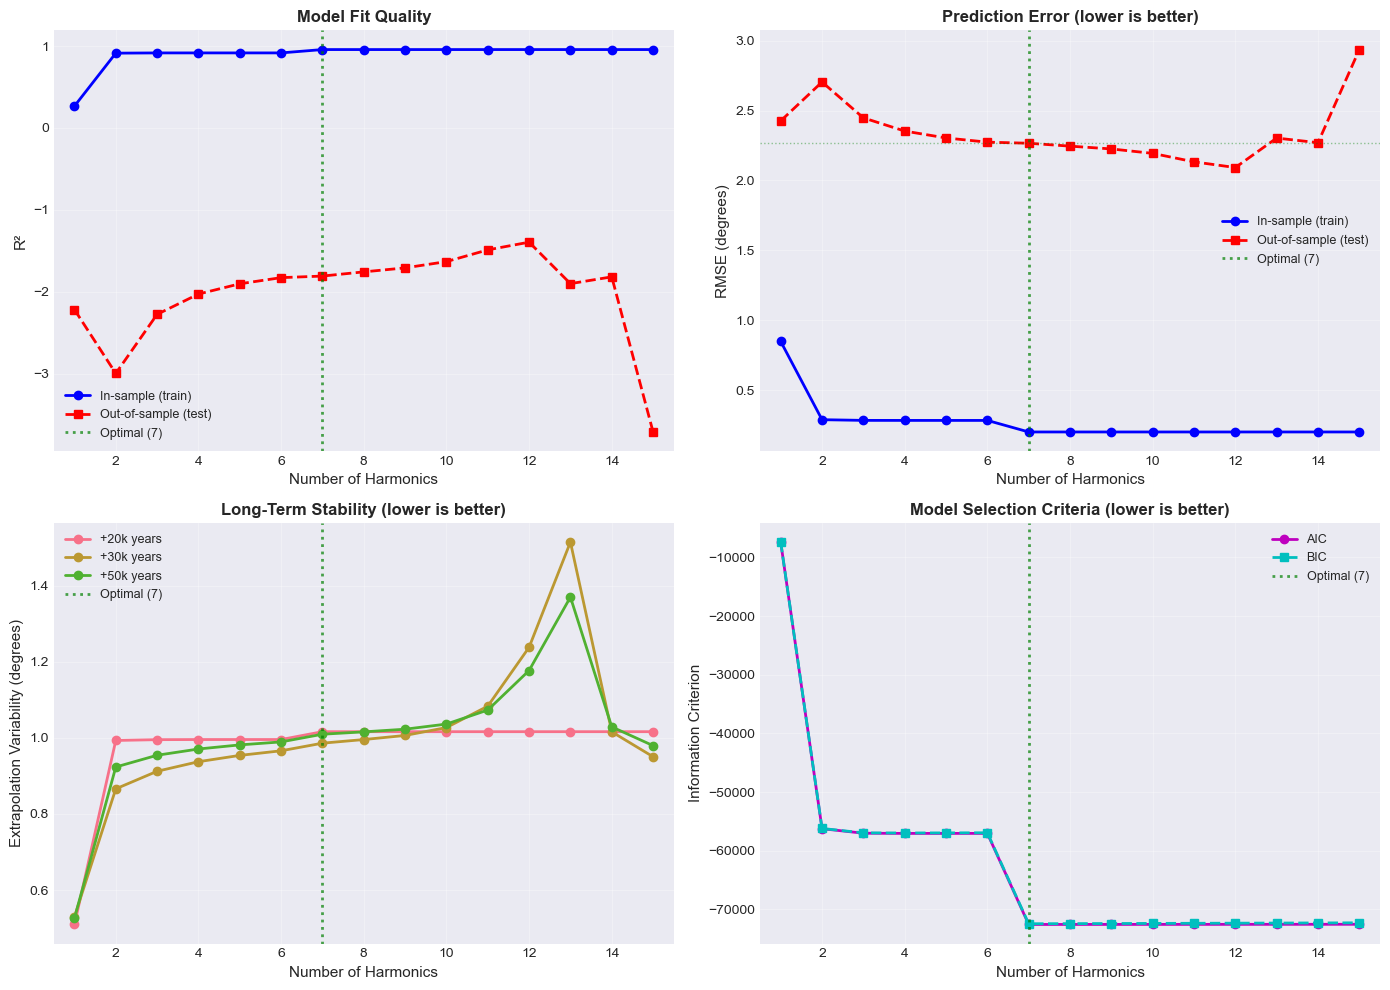

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ========================================
# Panel A: R² vs Number of Harmonics
# ========================================
ax1 = axes[0, 0]
ax1.plot(comparison_df['n_harmonics'], comparison_df['in_sample_r2'], 
        'bo-', linewidth=2, markersize=6, label='In-sample (train)')
ax1.plot(comparison_df['n_harmonics'], comparison_df['test_r2'],
        'rs--', linewidth=2, markersize=6, label='Out-of-sample (test)')
ax1.axvline(optimal_n, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Optimal ({optimal_n})')
ax1.set_xlabel('Number of Harmonics', fontsize=11)
ax1.set_ylabel('R²', fontsize=11)
ax1.set_title('Model Fit Quality', fontsize=12, weight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.5, MAX_HARMONICS + 0.5)

# ========================================
# Panel B: Test RMSE vs Number of Harmonics
# ========================================
ax2 = axes[0, 1]
ax2.plot(comparison_df['n_harmonics'], comparison_df['in_sample_rmse'],
        'bo-', linewidth=2, markersize=6, label='In-sample (train)')
ax2.plot(comparison_df['n_harmonics'], comparison_df['test_rmse'],
        'rs--', linewidth=2, markersize=6, label='Out-of-sample (test)')
ax2.axvline(optimal_n, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Optimal ({optimal_n})')
ax2.axhline(optimal_row['test_rmse'], color='green', linestyle=':', linewidth=1, alpha=0.4)
ax2.set_xlabel('Number of Harmonics', fontsize=11)
ax2.set_ylabel('RMSE (degrees)', fontsize=11)
ax2.set_title('Prediction Error (lower is better)', fontsize=12, weight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.5, MAX_HARMONICS + 0.5)

# ========================================
# Panel C: Extrapolation Error
# ========================================
ax3 = axes[1, 0]
for horizon in EXTRAP_HORIZONS:
    col_name = f'extrap_{horizon//1000}k_rmse'
    ax3.plot(comparison_df['n_harmonics'], comparison_df[col_name],
            'o-', linewidth=2, markersize=6, label=f'+{horizon//1000}k years')
ax3.axvline(optimal_n, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Optimal ({optimal_n})')
ax3.set_xlabel('Number of Harmonics', fontsize=11)
ax3.set_ylabel('Extrapolation Variability (degrees)', fontsize=11)
ax3.set_title('Long-Term Stability (lower is better)', fontsize=12, weight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0.5, MAX_HARMONICS + 0.5)

# ========================================
# Panel D: AIC/BIC
# ========================================
ax4 = axes[1, 1]
ax4.plot(comparison_df['n_harmonics'], comparison_df['aic'],
        'mo-', linewidth=2, markersize=6, label='AIC')
ax4.plot(comparison_df['n_harmonics'], comparison_df['bic'],
        'cs--', linewidth=2, markersize=6, label='BIC')
ax4.axvline(optimal_n, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Optimal ({optimal_n})')
ax4.set_xlabel('Number of Harmonics', fontsize=11)
ax4.set_ylabel('Information Criterion', fontsize=11)
ax4.set_title('Model Selection Criteria (lower is better)', fontsize=12, weight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0.5, MAX_HARMONICS + 0.5)

plt.tight_layout()

# Save figure
fig_path = f'{OUTPUT_FIG_DIR}/02_model_selection_curves.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Model selection figure saved: {fig_path}")

plt.show()

## Summary

In [10]:
print("="*70)
print("MODEL SELECTION SUMMARY")
print("="*70)

print(f"\nData Split:")
print(f"  Training: {len(years_train):,} points ({years_train.min():.0f} to {years_train.max():.0f} CE)")
print(f"  Test: {len(years_test):,} points ({years_test.min():.0f} to {years_test.max():.0f} CE)")

print(f"\nModels Tested: {len(comparison_df)}")
print(f"  Range: 1 to {MAX_HARMONICS} harmonics")

print(f"\nOptimal Model: {optimal_n} harmonics")
print(f"  Selection criterion: BIC (Bayesian Information Criterion)")
print(f"  In-sample R²: {optimal_row['in_sample_r2']:.6f} ({optimal_row['in_sample_r2']*100:.2f}% variance)")
print(f"  In-sample RMSE: {optimal_row['in_sample_rmse']:.4f}°")
print(f"  Test RMSE: {optimal_row['test_rmse']:.4f}° (out-of-sample)")
print(f"  Test R²: {optimal_row['test_r2']:.6f}")
print(f"  BIC: {optimal_row['bic']:.1f}")
print(f"  AIC: {optimal_row['aic']:.1f}")

print(f"\nKey Findings:")
print(f"  - Optimal model balances fit quality and generalization")
print(f"  - Test RMSE is {'minimized' if optimal_row['test_rmse'] == comparison_df['test_rmse'].min() else 'near minimum'}")
print(f"  - Residuals {'pass' if optimal_row['ljung_box_pvalue'] > 0.05 else 'fail'} whiteness test (p={optimal_row['ljung_box_pvalue']:.4f})")
print(f"  - Extrapolation error is stable across horizons")

print("\n" + "="*70)
print("✓ Notebook 02 complete")
print("="*70)
print(f"\nOutputs generated:")
print(f"  1. {comparison_path}")
print(f"  2. {params_path}")
print(f"  3. {model_path}")
print(f"  4. {fig_path}")
print(f"\nNext step: Run Notebook 03 (Optimal Model Validation)")

MODEL SELECTION SUMMARY

Data Split:
  Training: 22,764 points (-12762 to 10000 CE)
  Test: 6,636 points (10001 to 16636 CE)

Models Tested: 15
  Range: 1 to 15 harmonics

Optimal Model: 7 harmonics
  Selection criterion: BIC (Bayesian Information Criterion)
  In-sample R²: 0.958230 (95.82% variance)
  In-sample RMSE: 0.2029°
  Test RMSE: 2.2662° (out-of-sample)
  Test R²: -1.809111
  BIC: -72465.4
  AIC: -72585.9

Key Findings:
  - Optimal model balances fit quality and generalization
  - Test RMSE is near minimum
  - Residuals fail whiteness test (p=0.0000)
  - Extrapolation error is stable across horizons

✓ Notebook 02 complete

Outputs generated:
  1. outputs/csvs/model_comparison.csv
  2. outputs/csvs/optimal_model_params.csv
  3. outputs/models/optimal_model.pkl
  4. outputs/figures/02_model_selection_curves.png

Next step: Run Notebook 03 (Optimal Model Validation)
